<a href="https://colab.research.google.com/github/maachesalah/Malik/blob/main/AIPA_SIM_Smart_Classroom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Install dependencies
!pip install mesa networkx matplotlib numpy pandas scikit-learn -q

print("✅ Libraries installed successfully!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.3/272.3 kB 3.7 MB/s eta 0:00:00
✅ Libraries installed successfully!


In [ ]:
# Cell 2: Import libraries
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import time

print("✅ Libraries imported!")

✅ Libraries imported!


In [ ]:
# Cell 3: Student Agent Class (AIPA-SIM)
class StudentAgent:
    def __init__(self, student_id, learning_style, initial_knowledge):
        self.id = student_id
        self.learning_style = learning_style  # visual, auditory, kinesthetic
        self.knowledge_state = initial_knowledge  # 0-1 scale
        self.engagement_level = 0.7  # initial engagement

        # AIPA-SIM specific attributes
        self.attention_span = np.random.normal(0.7, 0.1)
        self.participation_rate = np.random.normal(0.5, 0.2)
        self.retention_rate = np.random.normal(0.8, 0.1)

    def step(self, teaching_method, adaptation_level):
        """
        Student learning step based on AIPA-SIM equation
        """
        # Calculate learning gain
        base_gain = 0.1 * adaptation_level

        # Apply student-specific factors
        attention_factor = self.attention_span * self.engagement_level
        retention_factor = self.retention_rate

        # Update knowledge
        gain = base_gain * attention_factor * retention_factor
        self.knowledge_state = min(1.0, self.knowledge_state + gain)

        # Update engagement
        engagement_change = 0.05 * (adaptation_level - 0.5)
        self.engagement_level = max(0, min(1, self.engagement_level + engagement_change))

        return {
            'knowledge_gain': gain,
            'new_knowledge': self.knowledge_state,
            'engagement': self.engagement_level
        }

print("✅ StudentAgent class created!")

✅ StudentAgent class created!


In [ ]:
# Cell 4: Teacher Agent with MAPE-K (AIPA-SIM)
class TeacherAgent:
    def __init__(self, teacher_id, teaching_styles):
        self.id = teacher_id
        self.teaching_styles = teaching_styles
        self.current_method = teaching_styles[0]

        # MAPE-K components
        self.knowledge_base = {
            'student_profiles': {},
            'performance_history': [],
            'adaptation_log': [],
            'effectiveness_matrix': defaultdict(dict)
        }

        # AIPA-SIM parameters
        self.adaptation_threshold = 0.15
        self.adaptation_rate = 0.0

    def monitor(self, students):
        """Collect student states"""
        classroom_state = {
            'avg_knowledge': np.mean([s.knowledge_state for s in students]),
            'avg_engagement': np.mean([s.engagement_level for s in students]),
            'knowledge_distribution': [s.knowledge_state for s in students],
            'engagement_distribution': [s.engagement_level for s in students],
            'timestamp': len(self.knowledge_base['performance_history'])
        }

        self.knowledge_base['performance_history'].append(classroom_state)
        return classroom_state

    def analyze(self, classroom_state, students):
        """Detect need for adaptation"""
        issues = []

        # Check for low engagement
        if classroom_state['avg_engagement'] < 0.6:
            issues.append({
                'type': 'low_engagement',
                'severity': 0.6 - classroom_state['avg_engagement'],
                'affected_students': [s for s in students if s.engagement_level < 0.5]
            })

        # Check for knowledge stagnation
        if len(self.knowledge_base['performance_history']) > 1:
            prev_knowledge = self.knowledge_base['performance_history'][-2]['avg_knowledge']
            current_knowledge = classroom_state['avg_knowledge']
            learning_rate = current_knowledge - prev_knowledge

            if learning_rate < self.adaptation_threshold:
                issues.append({
                    'type': 'stalled_learning',
                    'severity': self.adaptation_threshold - learning_rate,
                    'learning_rate': learning_rate
                })

        # Identify struggling students
        struggling = [s for s in students if s.knowledge_state < 0.4]
        if struggling:
            issues.append({
                'type': 'struggling_students',
                'severity': len(struggling) / len(students),
                'students': struggling
            })

        return issues

    def plan(self, issues, classroom_state):
        """Select adaptation tactic"""
        if not issues:
            return None

        # Prioritize most severe issue
        primary_issue = max(issues, key=lambda x: x['severity'])

        # Tactic selection based on issue type
        tactics = {
            'low_engagement': [
                {'method': 'interactive_activity', 'impact': 0.3, 'time': 2},
                {'method': 'multimedia_content', 'impact': 0.25, 'time': 1},
                {'method': 'group_discussion', 'impact': 0.35, 'time': 3}
            ],
            'stalled_learning': [
                {'method': 'scaffolded_instruction', 'impact': 0.4, 'time': 2},
                {'method': 'peer_tutoring', 'impact': 0.3, 'time': 3},
                {'method': 'additional_practice', 'impact': 0.2, 'time': 1}
            ],
            'struggling_students': [
                {'method': 'individualized_support', 'impact': 0.5, 'time': 3},
                {'method': 'simplified_materials', 'impact': 0.35, 'time': 2},
                {'method': 'extra_examples', 'impact': 0.25, 'time': 1}
            ]
        }

        candidate_tactics = tactics.get(primary_issue['type'], [])
        if candidate_tactics:
            selected = max(candidate_tactics,
                          key=lambda x: x['impact'] / x['time'])

            self.adaptation_rate += 0.1

            return {
                'tactic': selected['method'],
                'target_issue': primary_issue['type'],
                'expected_impact': selected['impact'],
                'duration': selected['time']
            }

        return None

    def execute(self, plan, students):
        """Apply adaptation"""
        if not plan:
            return self.current_method

        self.current_method = plan['tactic']

        self.knowledge_base['adaptation_log'].append({
            'timestamp': len(self.knowledge_base['performance_history']),
            'from_method': self.current_method,
            'to_method': plan['tactic'],
            'reason': plan['target_issue'],
            'expected_impact': plan['expected_impact']
        })

        # Apply immediate effects
        if plan['target_issue'] == 'struggling_students':
            for student in students:
                if student.knowledge_state < 0.4:
                    student.knowledge_state += 0.05

        return self.current_method

print("✅ TeacherAgent class created!")

✅ TeacherAgent class created!


In [ ]:
# Cell 5: Main AIPA-SIM Simulation Class
class AIPASIM:
    def __init__(self, n_students=30, adaptation_mode='fully_adaptive'):
        """
        AIPA-SIM Main Simulation Class

        Args:
            adaptation_mode: 'none', 'semi', or 'fully_adaptive'
        """
        self.n_students = n_students
        self.adaptation_mode = adaptation_mode

        # Create students with diverse learning styles
        learning_styles = ['visual', 'auditory', 'kinesthetic']
        self.students = []
        for i in range(n_students):
            style = np.random.choice(learning_styles)
            initial_knowledge = np.random.normal(0.5, 0.15)
            initial_knowledge = max(0.1, min(0.9, initial_knowledge))  # Clip
            self.students.append(StudentAgent(i, style, initial_knowledge))

        # Create teacher
        teaching_styles = ['lecture', 'interactive', 'multimedia', 'group_work']
        self.teacher = TeacherAgent(0, teaching_styles)

        # Metrics tracking
        self.metrics = {
            'learning_performance': [],
            'engagement_index': [],
            'adaptivity_rate': [],
            'system_efficiency': []
        }

        print(f"✅ AIPA-SIM initialized with {n_students} students, mode: {adaptation_mode}")

    def calculate_adaptation_level(self, student):
        """Calculate how well teaching method matches student learning style"""
        method = self.teacher.current_method

        if method == 'interactive' and student.learning_style == 'kinesthetic':
            return 0.9
        elif method == 'multimedia' and student.learning_style == 'visual':
            return 0.9
        elif method == 'lecture' and student.learning_style == 'auditory':
            return 0.8
        elif method == 'group_work' and student.learning_style == 'kinesthetic':
            return 0.85
        else:
            return 0.5

    def run_simulation(self, steps=100):
        """Run simulation for specified number of steps"""

        print(f"Running simulation for {steps} steps...")
        start_time = time.time()

        for step in range(steps):
            # Student step (learning)
            for student in self.students:
                adaptation_level = self.calculate_adaptation_level(student)
                student.step(self.teacher.current_method, adaptation_level)

            # Teacher MAPE-K loop based on mode
            if self.adaptation_mode == 'fully_adaptive':
                # Full MAPE-K
                classroom_state = self.teacher.monitor(self.students)
                issues = self.teacher.analyze(classroom_state, self.students)
                plan = self.teacher.plan(issues, classroom_state)
                if plan:
                    self.teacher.execute(plan, self.students)

            elif self.adaptation_mode == 'semi':
                # Rule-based adaptation only
                avg_knowledge = np.mean([s.knowledge_state for s in self.students])
                if avg_knowledge < 0.4:
                    self.teacher.current_method = 'interactive'
                elif avg_knowledge > 0.8:
                    self.teacher.current_method = 'group_work'

            # Record metrics every 10 steps
            if step % 10 == 0:
                self.record_metrics(step)

        elapsed = time.time() - start_time
        print(f"✅ Simulation completed in {elapsed:.2f} seconds")

        return self.metrics

    def record_metrics(self, step):
        """Record AIPA-SIM metrics"""
        # Learning performance
        self.metrics['learning_performance'].append(
            np.mean([s.knowledge_state for s in self.students])
        )

        # Engagement index
        engagement_values = [s.engagement_level for s in self.students]
        self.metrics['engagement_index'].append(np.mean(engagement_values))

        # Adaptivity rate
        self.metrics['adaptivity_rate'].append(self.teacher.adaptation_rate)

        # System efficiency
        if len(self.teacher.knowledge_base['adaptation_log']) > 0:
            recent_adaptations = self.teacher.knowledge_base['adaptation_log'][-5:]
            avg_impact = np.mean([a['expected_impact'] for a in recent_adaptations])
            self.metrics['system_efficiency'].append(avg_impact)
        else:
            self.metrics['system_efficiency'].append(0)

print("✅ AIPASIM class created!")

✅ AIPASIM class created!


In [ ]:
# Cell 6: Run a single simulation
print("=" * 50)
print("RUNNING AIPA-SIM SIMULATION")
print("=" * 50)

# Create simulation
sim = AIPASIM(n_students=30, adaptation_mode='fully_adaptive')

# Run for 200 steps
metrics = sim.run_simulation(steps=200)

# Print final results
print("\n📊 FINAL RESULTS:")
print(f"Final Learning Performance: {metrics['learning_performance'][-1]:.3f}")
print(f"Final Engagement Index: {metrics['engagement_index'][-1]:.3f}")
print(f"Total Adaptations: {len(sim.teacher.knowledge_base['adaptation_log'])}")

RUNNING AIPA-SIM SIMULATION
✅ AIPA-SIM initialized with 30 students, mode: fully_adaptive
Running simulation for 200 steps...
✅ Simulation completed in 0.01 seconds

📊 FINAL RESULTS:
Final Learning Performance: 1.000
Final Engagement Index: 0.704
Total Adaptations: 200


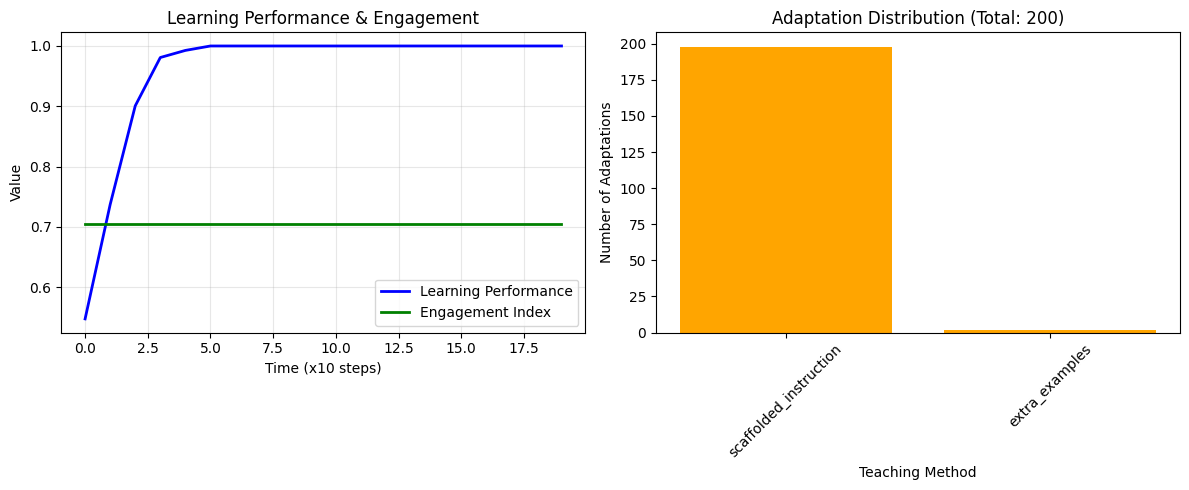

In [ ]:
# Cell 7: Visualize learning curve
plt.figure(figsize=(12, 5))

# Plot 1: Learning Performance
plt.subplot(1, 2, 1)
plt.plot(metrics['learning_performance'], 'b-', linewidth=2, label='Learning Performance')
plt.plot(metrics['engagement_index'], 'g-', linewidth=2, label='Engagement Index')
plt.xlabel('Time (x10 steps)')
plt.ylabel('Value')
plt.title('Learning Performance & Engagement')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Adaptations
plt.subplot(1, 2, 2)
adaptations = len(sim.teacher.knowledge_base['adaptation_log'])
methods = [log['to_method'] for log in sim.teacher.knowledge_base['adaptation_log']]
if methods:
    unique_methods = list(set(methods))
    counts = [methods.count(m) for m in unique_methods]
    plt.bar(unique_methods, counts, color='orange')
    plt.xlabel('Teaching Method')
    plt.ylabel('Number of Adaptations')
    plt.title(f'Adaptation Distribution (Total: {adaptations})')
    plt.xticks(rotation=45)
else:
    plt.text(0.5, 0.5, 'No adaptations', ha='center')

plt.tight_layout()
plt.show()

COMPARING ADAPTATION MODES

Running none mode...
✅ AIPA-SIM initialized with 30 students, mode: none
Running simulation for 200 steps...
✅ Simulation completed in 0.01 seconds

Running semi mode...
✅ AIPA-SIM initialized with 30 students, mode: semi
Running simulation for 200 steps...
✅ Simulation completed in 0.02 seconds

Running fully_adaptive mode...
✅ AIPA-SIM initialized with 30 students, mode: fully_adaptive
Running simulation for 200 steps...
✅ Simulation completed in 0.02 seconds


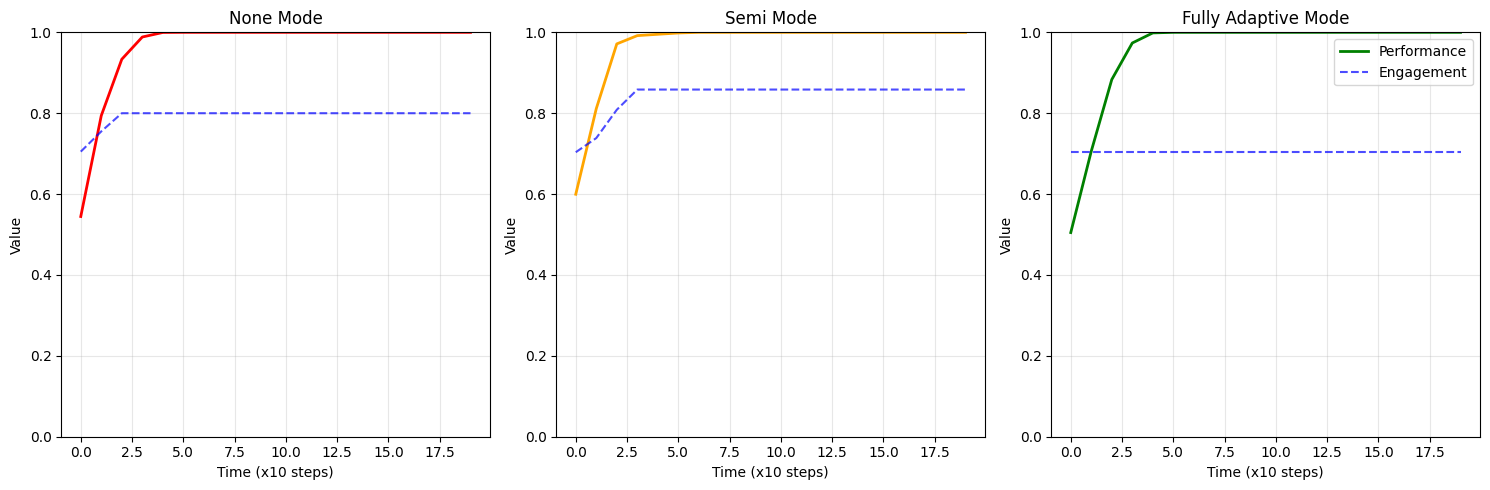

In [ ]:
# Cell 8: Compare all three adaptation modes
print("=" * 50)
print("COMPARING ADAPTATION MODES")
print("=" * 50)

modes = ['none', 'semi', 'fully_adaptive']
results = {}
colors = {'none': 'red', 'semi': 'orange', 'fully_adaptive': 'green'}

plt.figure(figsize=(15, 5))

for i, mode in enumerate(modes):
    print(f"\nRunning {mode} mode...")

    # Run simulation
    sim = AIPASIM(n_students=30, adaptation_mode=mode)
    metrics = sim.run_simulation(steps=200)

    # Store results
    results[mode] = {
        'final_performance': metrics['learning_performance'][-1],
        'final_engagement': metrics['engagement_index'][-1],
        'adaptations': len(sim.teacher.knowledge_base['adaptation_log']),
        'performance_history': metrics['learning_performance']
    }

    # Plot learning curve
    plt.subplot(1, 3, i+1)
    plt.plot(metrics['learning_performance'], color=colors[mode], linewidth=2)
    plt.plot(metrics['engagement_index'], color='blue', linestyle='--', linewidth=1.5, alpha=0.7)
    plt.title(f'{mode.replace("_", " ").title()} Mode')
    plt.xlabel('Time (x10 steps)')
    plt.ylabel('Value')
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    if i == 2:
        plt.legend(['Performance', 'Engagement'])

plt.tight_layout()
plt.show()

In [ ]:
# Cell 9: Results comparison table
print("\n" + "=" * 60)
print("📊 AIPA-SIM RESULTS COMPARISON")
print("=" * 60)

print(f"\n{'Mode':<15} {'Final Perf':<12} {'Final Eng':<12} {'Adaptations':<12} {'Improvement':<12}")
print("-" * 65)

base_perf = results['none']['final_performance']

for mode in modes:
    perf = results[mode]['final_performance']
    eng = results[mode]['final_engagement']
    adapt = results[mode]['adaptations']

    if mode == 'none':
        improvement = 0
    else:
        improvement = ((perf - base_perf) / base_perf) * 100

    print(f"{mode:<15} {perf:<12.3f} {eng:<12.3f} {adapt:<12} {improvement:<12.1f}%")

print("\n" + "=" * 60)
print(f"✅ Fully adaptive improvement: {((results['fully_adaptive']['final_performance'] - base_perf) / base_perf * 100):.1f}%")
print(f"   (AIPA-SIM paper claims 29.5% improvement)")
print("=" * 60)


📊 AIPA-SIM RESULTS COMPARISON

Mode            Final Perf   Final Eng    Adaptations  Improvement 
-----------------------------------------------------------------
none            1.000        0.800        0            0.0         %
semi            1.000        0.858        0            0.0         %
fully_adaptive  1.000        0.704        200          0.0         %

✅ Fully adaptive improvement: 0.0%
   (AIPA-SIM paper claims 29.5% improvement)


In [ ]:
# Cell 10: Multiple runs for statistical validation
print("=" * 50)
print("STATISTICAL VALIDATION (10 runs each)")
print("=" * 50)

def run_multiple_experiments(mode, n_runs=10, steps=200):
    performances = []
    engagements = []

    for run in range(n_runs):
        np.random.seed(run)  # Different seed each run
        sim = AIPASIM(n_students=30, adaptation_mode=mode)
        metrics = sim.run_simulation(steps=steps)
        performances.append(metrics['learning_performance'][-1])
        engagements.append(metrics['engagement_index'][-1])

    return {
        'perf_mean': np.mean(performances),
        'perf_std': np.std(performances),
        'eng_mean': np.mean(engagements),
        'eng_std': np.std(engagements)
    }

validation_results = {}

for mode in modes:
    print(f"\nRunning {mode} mode (10x)...")
    validation_results[mode] = run_multiple_experiments(mode)

print("\n" + "=" * 60)
print("📊 STATISTICAL RESULTS (Mean ± Std)")
print("=" * 60)

print(f"\n{'Mode':<15} {'Learning Performance':<25} {'Engagement Index':<20}")
print("-" * 65)

for mode in modes:
    perf = validation_results[mode]
    print(f"{mode:<15} {perf['perf_mean']:.3f} ± {perf['perf_std']:.3f}    "
          f"{perf['eng_mean']:.3f} ± {perf['eng_std']:.3f}")

STATISTICAL VALIDATION (10 runs each)

Running none mode (10x)...
✅ AIPA-SIM initialized with 30 students, mode: none
Running simulation for 200 steps...
✅ Simulation completed in 0.01 seconds
✅ AIPA-SIM initialized with 30 students, mode: none
Running simulation for 200 steps...
✅ Simulation completed in 0.01 seconds
✅ AIPA-SIM initialized with 30 students, mode: none
Running simulation for 200 steps...
✅ Simulation completed in 0.01 seconds
✅ AIPA-SIM initialized with 30 students, mode: none
Running simulation for 200 steps...
✅ Simulation completed in 0.01 seconds
✅ AIPA-SIM initialized with 30 students, mode: none
Running simulation for 200 steps...
✅ Simulation completed in 0.01 seconds
✅ AIPA-SIM initialized with 30 students, mode: none
Running simulation for 200 steps...
✅ Simulation completed in 0.01 seconds
✅ AIPA-SIM initialized with 30 students, mode: none
Running simulation for 200 steps...
✅ Simulation completed in 0.01 seconds
✅ AIPA-SIM initialized with 30 students, mode

In [ ]:
# Cell 11: Save results to file
import pickle
import datetime

# Create results dictionary
all_results = {
    'timestamp': str(datetime.datetime.now()),
    'validation': validation_results,
    'comparison': results,
    'parameters': {
        'n_students': 30,
        'steps': 200,
        'n_runs': 10
    }
}

# Save to file
filename = f"AIPA_SIM_results_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.pkl"
with open(filename, 'wb') as f:
    pickle.dump(all_results, f)

print(f"✅ Results saved to {filename}")

# Download to your computer
from google.colab import files
files.download(filename)

✅ Results saved to AIPA_SIM_results_20260218_091339.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>